In [ ]:
# SETTING UP THE ENVIRONMENT
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import zipfile
import json
from pathlib import Path

# TensorFlow and Keras Components
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Hugging Face Transformers
from transformers import BertTokenizer, TFBertModel, logging as hf_logging

# Scikit-learn for ML Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Google Colab Specifics (for file handling)
from google.colab import files, drive
from IPython.display import Image, display

# To keep our output clean, we'll suppress the less critical warnings from Transformers.
hf_logging.set_verbosity_error()

print(" All libraries are installed and imported successfully.")

 All libraries are installed and imported successfully.


In [ ]:
# DATA LOADING AND PREPARATION
print("\n Loading and Preparing the Dataset")

# Upload and Unzip the Dataset
try:
    # Upload 'archive.zip
    uploaded = files.upload()

    # Create a directory to store our data and extract the contents.
    with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data')
    print("Dataset unzipped successfully into '/content/data'.")

except Exception as e:
    print(f" An error occurred: {e}")
    print("   Please make sure you have uploaded a file named 'archive.zip'.")


# Load Datasets into Pandas
# Load the 'Fake.csv' and 'True.csv' files into pandas DataFrames.
try:
    fake_df = pd.read_csv('/content/data/Fake.csv')
    true_df = pd.read_csv('/content/data/True.csv')
    print(" CSV files loaded into DataFrames.")
except FileNotFoundError:
    print(" Error: Could not find the CSV files. Ensure they were extracted correctly.")
    exit()

# Clean the Text Data
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)                 # Strip out HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)           # Keep only alphabetic characters and spaces
    text = text.lower()                               # Convert everything to lowercase
    text = re.sub(r'\s+', ' ', text).strip()          # Normalize whitespace
    return text

# Data Leakage
true_df['text'] = true_df['text'].apply(lambda x: x.split(' - ', 1)[-1])

# Combine, Label, and Shuffle
# Add our target labels: 1 for 'Fake' news, 0 for 'Real' news.
fake_df['label'] = 1
true_df['label'] = 0

# Merge the two DataFrames into one.
combined_df = pd.concat([fake_df, true_df])

# Shuffle the dataset
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a Unified Input Feature
df['content'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).apply(clean_text)

# Keep only the columns we need
df = df[['content', 'label']]

print(f"\nTotal articles in the dataset: {len(df)}")
print("Class distribution:\n", df['label'].value_counts(normalize=True))

# Split Data into Training, Validation, and Test Sets

# First, separate out the training set (80%).
X_train, X_temp, Y_train, Y_temp = train_test_split(
    df['content'], df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Split the remaining 20% into validation and test sets (10% each).
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp,
    test_size=0.5,
    random_state=42,
    stratify=Y_temp
)

print("\n--- Data Split Summary ---")
print(f"Training data:   {len(X_train)} samples")
print(f"Validation data: {len(X_val)} samples")
print(f"Test data:       {len(X_test)} samples")



 Loading and Preparing the Dataset


Saving archive.zip to archive.zip
Dataset unzipped successfully into '/content/data'.
 CSV files loaded into DataFrames.

Total articles in the dataset: 44898
Class distribution:
 label
1    0.522985
0    0.477015
Name: proportion, dtype: float64

--- Data Split Summary ---
Training data:   35918 samples
Validation data: 4490 samples
Test data:       4490 samples


In [ ]:
# TEXT TOKENIZATION FOR BERT
# Initialize the BERT Tokenizer
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Create a Reusable Tokenization Function
def tokenize_data(texts, tokenizer, max_len):
    """
    Converts a list of texts into BERT-compatible input format.
    Returns a dictionary of TensorFlow tensors.
    """
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,      # Adds [CLS] and [SEP] tokens
        max_length=max_len,           # Truncates or pads to this length
        truncation=True,
        padding='max_length',         # Pads shorter sentences to max_len
        return_tensors='tf'           # Returns TensorFlow tensors
    )

# Tokenize all Data Splits
X_train_token = tokenize_data(X_train, tokenizer, MAX_LEN)
X_val_token = tokenize_data(X_val, tokenizer, MAX_LEN)
X_test_token = tokenize_data(X_test, tokenizer, MAX_LEN)

print(" Tokenization complete. Data is now ready for the model.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Tokenization complete. Data is now ready for the model.


Mounted at /content/drive
[Warning] 'config.json' not found. Using default parameters.
 Tokenizer loaded.
[Info] Could not load TensorFlow weights. Trying PyTorch weights (`from_pt=True`).
 Model architecture rebuilt successfully.

--- Model Reload Summary ---
   Model reloaded successfully from: /content/drive/MyDrive/fake_news_artifacts/run_20250919-080632
   Model Name:     bert-base-uncased
   Max Length:     128
   Threshold:      0.5
   Weights File:   final_model.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

--- Quick Demonstration ---

Text: "Former US attorney who negotiated Epstein’s 2008 plea deal w..."
  -> Probability (Fake): 0.266 | Prediction: REAL

Text: "Shocking discovery: scientists find that chocolate cures all..."
  -> Probability (Fake): 0.762 | Prediction: FAKE

--- Displaying Saved Evaluation Graphs ---

1. Training & Validation History


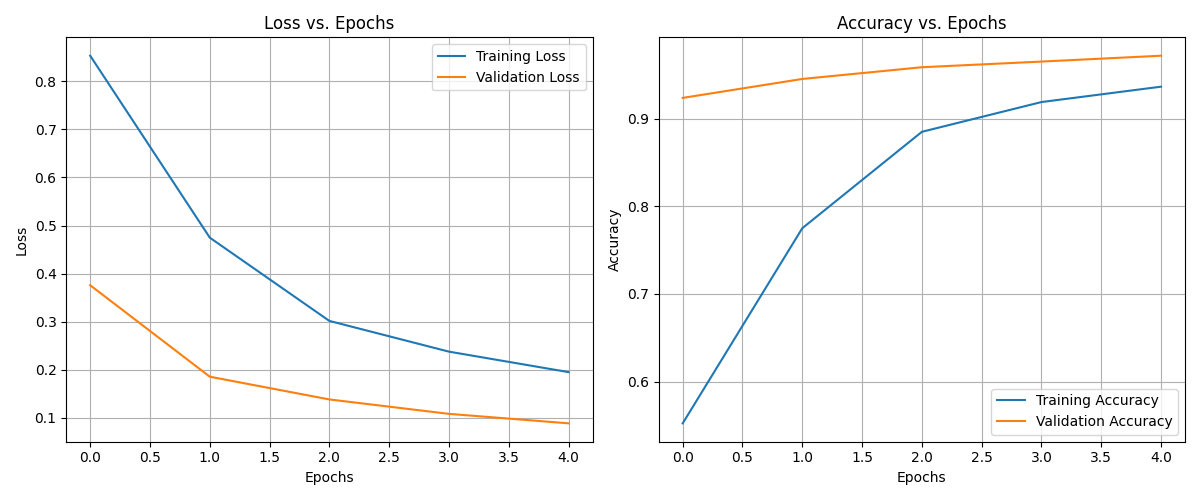


2. Confusion Matrix on the Test Set


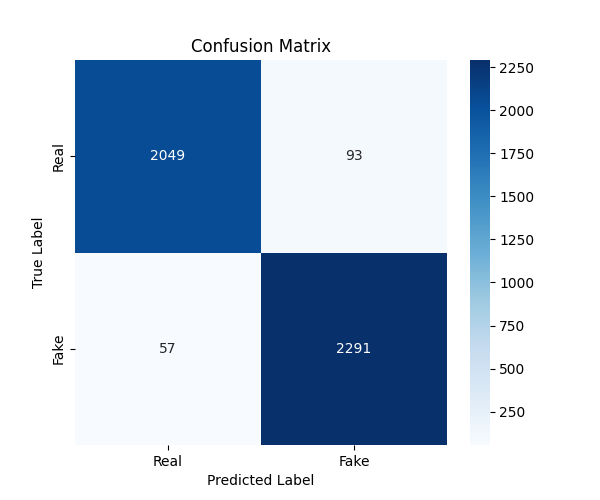

In [ ]:
# LOADING THE PRE-TRAINED MODEL & VISUALIZING RESULTS
import json
from pathlib import Path
import tensorflow as tf
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Layer
from tensorflow.keras.models import Model
from google.colab import drive
from IPython.display import display, Image

drive.mount('/content/drive', force_remount=True)

# Define the path where our model artifacts are saved.
ARTIFACTS_DIR = Path("/content/drive/MyDrive/fake_news_artifacts/run_20250919-080632")
HF_CACHE_DIR = Path("/content/drive/MyDrive/hf_cache")
HF_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# 1) Load Model Configuration
config_path = ARTIFACTS_DIR / "config.json"
if config_path.exists():
    config = json.loads(config_path.read_text())
    print(" Model configuration loaded from 'config.json'.")
else:
    config = {}
    print("[Warning] 'config.json' not found. Using default parameters.")

model_name = config.get("model_name", "bert-base-uncased")
max_len = int(config.get("max_len", 128))
threshold = float(config.get("threshold", 0.5))

# 2) Load the Tokenizer
tokenizer_dir = ARTIFACTS_DIR / "tokenizer"
tokenizer = AutoTokenizer.from_pretrained(
    str(tokenizer_dir) if tokenizer_dir.exists() else model_name,
    cache_dir=str(HF_CACHE_DIR)
)
print(" Tokenizer loaded.")

# 3) Rebuild the Model Architecture
class BertFeatureExtractor(Layer):
    def __init__(self, bert_model, **kwargs):
        super().__init__(**kwargs)
        self.bert = bert_model
    def call(self, inputs):
        return self.bert(inputs).last_hidden_state

def build_classifier_model(max_len, model_name):
    try:
        bert_base = TFBertModel.from_pretrained(model_name, from_tf=True, cache_dir=str(HF_CACHE_DIR))
    except Exception:
        print("[Info] Could not load TensorFlow weights. Trying PyTorch weights (`from_pt=True`).")
        bert_base = TFBertModel.from_pretrained(model_name, from_pt=True, cache_dir=str(HF_CACHE_DIR))

    bert_base.trainable = False
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    bert_features = BertFeatureExtractor(bert_base)({'input_ids': input_ids, 'attention_mask': attention_mask})
    conv_layer = Conv1D(filters=64, kernel_size=3, activation="relu")(bert_features)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dropout1 = Dropout(0.6)(pooling_layer)
    dense_layer = Dense(32, activation="tanh")(dropout1)
    dropout2 = Dropout(0.6)(dense_layer)
    output_layer = Dense(1, activation="sigmoid", name="classification")(dropout2)
    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

model = build_classifier_model(max_len, model_name)
print(" Model architecture rebuilt successfully.")

# 4) Load the Saved Weights
weights_path = None
for fname in ["final_model.weights.h5", "fake_news_classifier.weights.h5"]:
    if (ARTIFACTS_DIR / fname).exists():
        weights_path = ARTIFACTS_DIR / fname
        break
if not weights_path:
    found_weights = list(ARTIFACTS_DIR.glob("*.weights.h5"))
    if found_weights:
        weights_path = found_weights[0]
    else:
        raise FileNotFoundError(f"Critical Error: No '*.weights.h5' file found in {ARTIFACTS_DIR}")

model.load_weights(str(weights_path))

print("\n--- Model Reload Summary ---")
print(f"   Model reloaded successfully from: {ARTIFACTS_DIR}")
print(f"   Model Name:     {model_name}")
print(f"   Max Length:     {max_len}")
print(f"   Threshold:      {threshold}")
print(f"   Weights File:   {weights_path.name}")

# 5) Quick Sanity Check
demo_texts = [
    "Former US attorney who negotiated Epstein’s 2008 plea deal will appear before House Oversight committee",
    "Shocking discovery: scientists find that chocolate cures all diseases."
]
encoded_texts = tokenizer(demo_texts, truncation=True, padding="max_length", max_length=max_len, return_tensors="tf")
probabilities = model.predict(dict(encoded_texts), batch_size=2).flatten()
predictions = (probabilities >= threshold).astype(int)

print("\n--- Quick Demonstration ---")
for text, prob, pred in zip(demo_texts, probabilities, predictions):
    label = "FAKE" if pred == 1 else "REAL"
    print(f"\nText: \"{text[:60]}...\"")
    print(f"  -> Probability (Fake): {prob:.3f} | Prediction: {label}")


# 6: Display Saved Evaluation Graphs
print("\n--- Displaying Saved Evaluation Graphs ---")

# Define the paths to the saved image files
history_plot_path = ARTIFACTS_DIR / "final_training_history.png"
cm_plot_path = ARTIFACTS_DIR / "confusion_matrix.png"

# Display the Training History Plot
if history_plot_path.exists():
    print("\n1. Training & Validation History")
    display(Image(filename=str(history_plot_path), width=700))
else:
    print(f"\n[Warning] Training history plot not found at: {history_plot_path}")

# Display the Confusion Matrix Plot
if cm_plot_path.exists():
    print("\n2. Confusion Matrix on the Test Set")
    display(Image(filename=str(cm_plot_path), width=400))
else:
    print(f"\n[Warning] Confusion matrix plot not found at: {cm_plot_path}")

In [ ]:
# Deploying with a Gradio Web Interface
import gradio as gr
import tensorflow as tf
import re
import os

#  Model Loading for Deployment
deployment_model = model
deployment_tokenizer = tokenizer

print("\nModel and tokenizer are ready for deployment.")

#  Prediction Logic
def clean_text_for_prediction(text):
    """Applies the same text cleaning steps used during training."""
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

def predict_fake_news(text):

    # 1. Clean the input text
    cleaned_text = clean_text_for_prediction(text)

    # 2. Tokenize the text using the loaded tokenizer
    inputs = deployment_tokenizer(
        cleaned_text,
        add_special_tokens=True,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

    # 3. Get prediction from the model
    prediction_score = deployment_model.predict({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    })[0][0]

    # 4. Format the output for Gradio's Label component
    fake_prob = float(prediction_score)
    real_prob = 1 - fake_prob
    return {'FAKE': fake_prob, 'REAL': real_prob}

#  Launch the Gradio Interface
examples = [
    ["BREAKING: A source close to the White House claims the president is secretly a lizard person. The evidence is undeniable, experts say."],
    ["The S&P 500 closed up 0.5% on Tuesday after the Federal Reserve announced it would hold interest rates steady, citing stable inflation figures."],
    ["You will be SHOCKED to learn about this one weird trick to lose weight. Doctors don't want you to know this simple secret."]
]

interface = gr.Interface(
    fn=predict_fake_news,
    inputs=gr.Textbox(lines=8, placeholder="Paste a news article, headline, or text snippet here..."),
    outputs=gr.Label(num_top_classes=2, label="Verdict"),
    title=" BERT-CNN Fake News Detector",
    description="This interface uses a fine-tuned BERT model with a CNN classifier to predict whether a text is REAL or FAKE. Paste an article below to see the result.",
    examples=examples
)

# Launch the app. Use debug=True to see errors in the console.
interface.launch(debug=True)


Model and tokenizer are ready for deployment.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://debb03a1357b9183e0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://debb03a1357b9183e0.gradio.live
